In [1]:
import os
import matplotlib.image as img
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
dataset_path = "C:\\Users\\psagv\\Downloads\\archive (20)\\Rice_Image_Dataset"

image_paths = []
image_labels = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if not os.path.isdir(category_path):
        continue

    for file in os.listdir(category_path):
        file_path = os.path.join(category_path, file)
        image_paths.append(file_path)
        image_labels.append(category)

df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

In [3]:
df

,image_path,label
0,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Arborio
1,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Arborio
2,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Arborio
3,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Arborio
4,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Arborio
...,...,...
74995,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Karacadag
74996,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Karacadag
74997,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Karacadag
74998,C:\Users\psagv\Downloads\archive (20)\Rice_Ima...,Karacadag


In [4]:
train_df, temp_df = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.4, stratify=temp_df['label'], random_state=42)

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 56250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


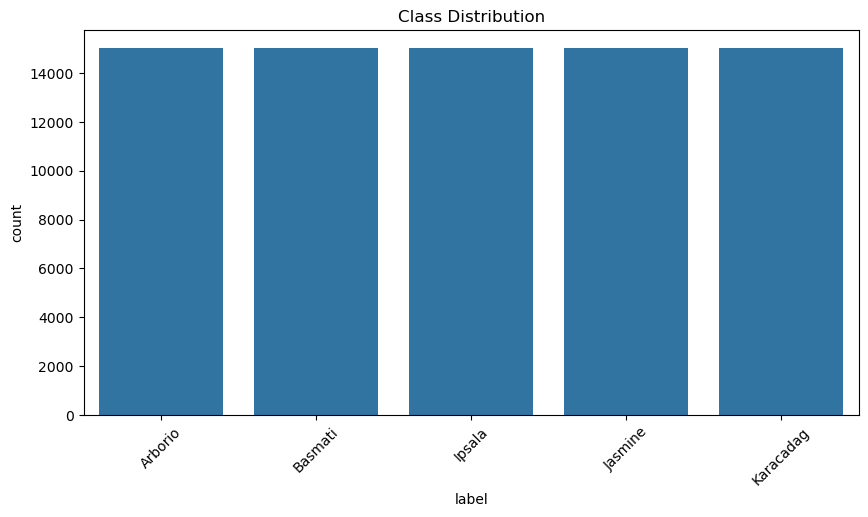

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

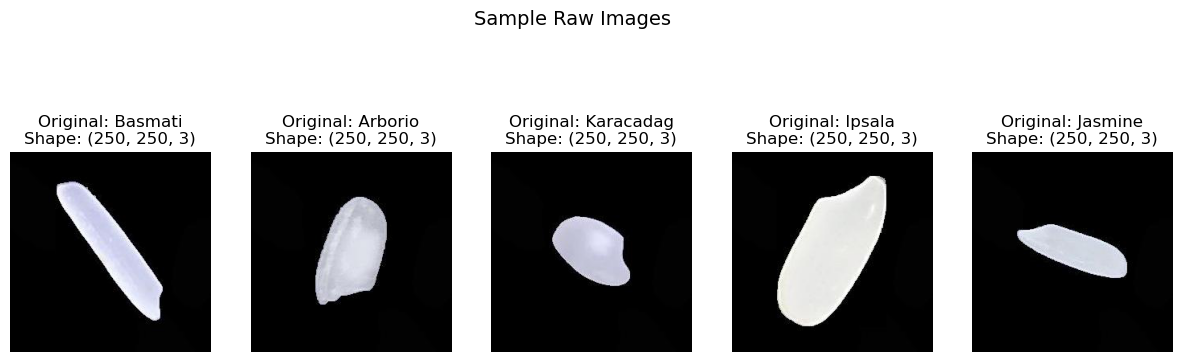

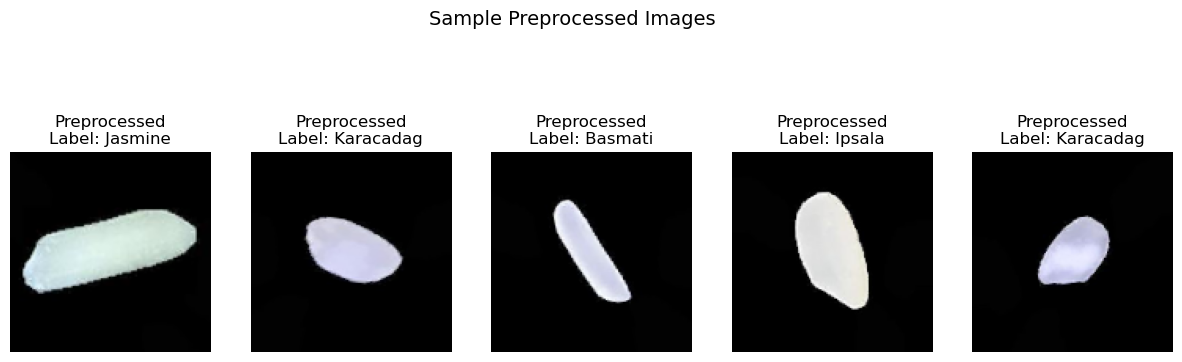

In [7]:
import matplotlib.pyplot as plt

def plot_sample_images(df, n=5):
    plt.figure(figsize=(15, 5))
    for i, (idx, row) in enumerate(df.sample(n).iterrows()):
        img = plt.imread(row['image_path'])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Original: {row['label']}\nShape: {img.shape}")
        plt.axis('off')
    plt.suptitle('Sample Raw Images', fontsize=14)
    plt.show()

def plot_preprocessed_images(generator, n=5):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(f"Preprocessed\nLabel: {class_names[np.argmax(labels[i])]}")
        plt.axis('off')
    plt.suptitle('Sample Preprocessed Images', fontsize=14)
    plt.show()

plot_sample_images(df)  # Raw images
plot_preprocessed_images(train_generator)  # Preprocessed

In [8]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\psagv\anaconda3\new_anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

C:\Users\psagv\anaconda3\new_anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1160s 658ms/step - accuracy: 0.8509 - loss: 0.3705 - val_accuracy: 0.8744 - val_loss: 0.3978
Epoch 2/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1177s 670ms/step - accuracy: 0.9694 - loss: 0.0861 - val_accuracy: 0.9478 - val_loss: 0.1685
Epoch 3/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 450s 256ms/step - accuracy: 0.9799 - loss: 0.0593 - val_accuracy: 0.9657 - val_loss: 0.0995
Epoch 4/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 438s 249ms/step - accuracy: 0.9823 - loss: 0.0551 - val_accuracy: 0.8013 - val_loss: 1.2384
Epoch 5/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 437s 248ms/step - accuracy: 0.9879 - loss: 0.0363 - val_accuracy: 0.8817 - val_loss: 0.5036


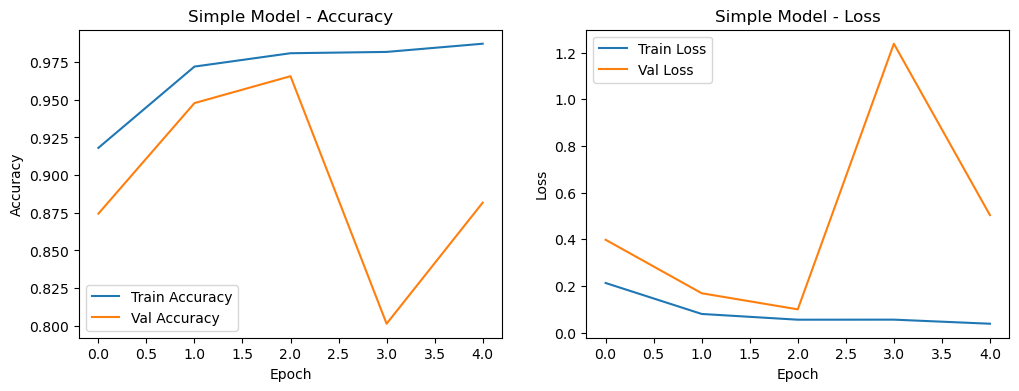

In [11]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history, 'Simple Model')


In [12]:
model.save("C:/Users/psagv/Rice_Model/model.h5")